# Time Series Modeling & Forecasting - with Exogenous Features

---

**Forecasting Cancellations**

> * **Goal:** Forecast cancellations for the given hotel data
> * **Why:** Predictions only work on preexisting reservations
    * *How can we forecast occupancy without depending on preexisting reservations?*
> * **How:** Using probabilities generated from prior classification modeling to forecast future cancellations

---

# **Imports**

In [2]:
## JNB tool to reload functions when called
%load_ext autoreload
%autoreload 2

In [3]:
## Enabling access to custom functions in separate directory

# Import necessary modules
import os
import sys

# Construct the absolute path to the 'src' directory
src_path = os.path.abspath(os.path.join('../..', 'src'))

# Append the path to 'sys.path'
if src_path not in sys.path:
    sys.path.append(src_path)

# import db_utils, eda
import time_series_modeling as tsm

In [4]:
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pmd
from pmdarima.arima import AutoARIMA, ndiffs, nsdiffs
from pmdarima.model_selection import train_test_split
from pmdarima.preprocessing import BoxCoxEndogTransformer, FourierFeaturizer
from pmdarima.pipeline import Pipeline
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn import metrics

# **Reading Data**

---

**Reading Data and Setting the Datetime Index**

> I will import the data I cleaned and prepped in advance for my modeling processes.
>
> I created an `arrival_date` column during the prep process containing the arrival date as a datetime object. Using this feature, I will reset my index to enable the time series modeling.

---

In [5]:
# with open('../../data/column_groups.json') as file:
#     col_dict = json.load(file)

# col_dict.keys()

In [6]:
# booking_cols = col_dict['booking_details']
# temporal_cols = col_dict['new_temporal_features']

# booking_cols.extend(temporal_cols)
# usecols = set(booking_cols)
# usecols

In [7]:
## Reading data and setting DT index
# path = '../../data/2.2_temporally_updated_data.feather'
# data = pd.read_feather(path, columns = ['ADR', 'ArrivalDate', 'DepartureDate'])
path = '../../data/3.3_data_exploded.feather'
# data = data.sort_values('ArrivalDate').reset_index(drop=True)#.set_index('ArrivalDate')
data = pd.read_feather(path)
data = data.set_index('Stay Date')
data

,ADR
Stay Date,
2015-07-01,0.00
2015-07-01,4.00
2015-07-01,55.68
2015-07-01,62.00
2015-07-01,62.50
...,...
2017-09-11,153.57
2017-09-12,99.06
2017-09-12,112.80


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 409257 entries, 2015-07-01 to 2017-09-13
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ADR     409257 non-null  float64
dtypes: float64(1)
memory usage: 6.2 MB


# Converting Reservations to Daily Records

In [9]:
# def calulate_date_range(data, start_date = 'ArrivalDate', end_date = 'DepartureDate'):
#     """
#     Calculate a date range based on the given start and end dates.

#     Parameters:
#     data (pandas.DataFrame): The data containing the start and end dates.
#     start_date (str): The column name of the start date.
#     end_date (str): The column name of the end date.

#     Returns:
#     pandas.DatetimeIndex: A date range from the start date to the end date (inclusive).

#     """
#     if data[start_date] == data[end_date]:
#         end_date = data[end_date] + pd.Timedelta(days=1)
#     else:
#         end_date = data[end_date] - pd.Timedelta(days=1)
    
#     return pd.date_range(start=start_date, end=end_date)
        
        
# def explode_reservations(df, start_date_col = 'ArrivalDate', end_date_col = 'DepartureDate'):
#     """
#     Explodes reservations in a DataFrame to individual days.

#     Args:
#         df (pandas.DataFrame): The DataFrame containing the reservations.
#         start_date_col (str): The name of the column in `df` that represents the start date of each reservation.
#         end_date_col (str): The name of the column in `df` that represents the end date of each reservation.

#     Returns:
#         pandas.DataFrame: The DataFrame with each reservation expanded to individual days.

#     Raises:
#         None

#     Example:
#         df = pd.DataFrame({'check_in': ['2022-01-01', '2022-02-01'],
#                            'check_out': ['2022-01-04', '2022-02-03']})
#         explode_reservations(df, 'check_in', 'check_out')

#     """
       
#     # Create a DataFrame with each guest's stay expanded to individual days
#     # Generate a range of dates for each row and store it in a new column
#     df['date_range'] = df.apply(calulate_date_range(row, start_date_col, end_date_col),
#                                 axis=1)

#     # Explode the date_range column to create a row for each date in the range
#     expanded_df = df.explode('date_range')

#     # Drop the original check_in and check_out columns if they are no longer needed
#     expanded_df = expanded_df.drop(columns=[start_date_col,
#                                             end_date_col])

#     # Rename the date_range column to date for clarity
#     expanded_df = expanded_df.rename(columns={'date_range': 'Stay Date'})

#     # Reset index if needed
#     expanded_df = expanded_df.reset_index(drop=True)

#     return expanded_df

***NOTE:*** This function will return `NaT` for reservations with the same arrival and departure dates.

Use pd.DataFrame.dropna() to resolve.

In [10]:
# def explode_reservations(df, start_date_col, end_date_col):
#     """
#     Explodes reservations in a DataFrame to individual days.

#     Args:
#         df (pandas.DataFrame): The DataFrame containing the reservations.
#         start_date_col (str): The name of the column in `df` that represents the start date of each reservation.
#         end_date_col (str): The name of the column in `df` that represents the end date of each reservation.

#     Returns:
#         pandas.DataFrame: The DataFrame with each reservation expanded to individual days.

#     Raises:
#         None

#     Example:
#         df = pd.DataFrame({'check_in': ['2022-01-01', '2022-02-01'],
#                            'check_out': ['2022-01-04', '2022-02-03']})
#         explode_reservations(df, 'check_in', 'check_out')

#     """
#     # Create a DataFrame with each guest's stay expanded to individual days
#     # Generate a range of dates for each row and store it in a new column
#     df['date_range'] = df.apply(lambda row: pd.date_range(start=row[start_date_col],
#                                                           end=row[end_date_col] - pd.Timedelta(days=1)),
#                                 axis=1)

#     # Explode the date_range column to create a row for each date in the range
#     expanded_df = df.explode('date_range')

#     # Drop the original check_in and check_out columns if they are no longer needed
#     expanded_df = expanded_df.drop(columns=[start_date_col,
#                                             end_date_col])

#     # Rename the date_range column to date for clarity
#     expanded_df = expanded_df.rename(columns={'date_range': 'Stay Date'})

#     # Reset index if needed
#     expanded_df = expanded_df.reset_index(drop=True)

#     return expanded_df

In [11]:
# expanded_data = explode_reservations(data, 'ArrivalDate', 'DepartureDate')
# expanded_data = expanded_data.dropna(subset = 'Stay Date')
# expanded_data

In [12]:
# expanded_data = (expanded_data.sort_values('Stay Date')
#                  .set_index('Stay Date'))
# expanded_data

# **Resampling**

---

**Resampling the Arrival Dates**

> My dataset includes multiple reservations per day, which makes sense, but also impairs the modeling process.
>
> **I will resample the data as daily averages for the modeling and forecasting process.**
* *Daily resampling* allows me to view the data for all reservations for a given day.
* *Computing the average cancellations* provides a normalized value allowing for easy comparisons between dates (without having to consider other features, such as occupancy, demand, etc.).

,ADR
Stay Date,
2015-07-03,90.40
2015-07-04,89.14
2015-07-05,89.90
2015-07-06,90.99
2015-07-07,91.16
...,...
2017-09-09,152.04
2017-09-10,154.97
2017-09-11,143.55


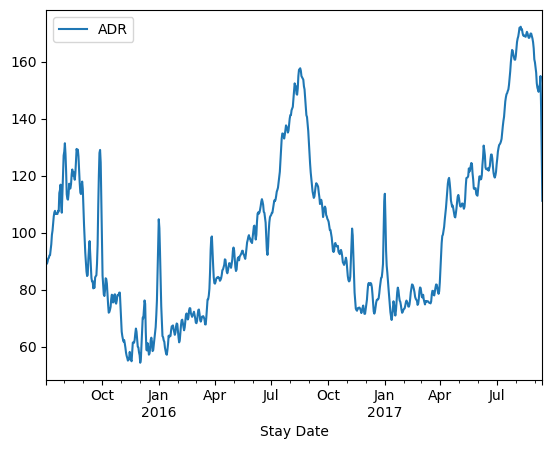

In [141]:
## Resampling for a rolling average daily cancellations with a three-day window
ts_avg = (data['ADR']
          .resample('D')
          .mean()
          .rolling(window=3)
          .mean()
          .dropna()
          .to_frame()
          .round(2))

display(ts_avg)
ts_avg.plot();

# Train/Test Split

---

I will split my data to reserve the last 90 days-worth of data for testing. In my experience, we usually focus on a short-term window for forecasting due to the increasing volatility as time goes on.

Ideally, I would prefer to forecast for an entire year, but due to the short timeline of my source data, I would have little data to use to train the model.

---

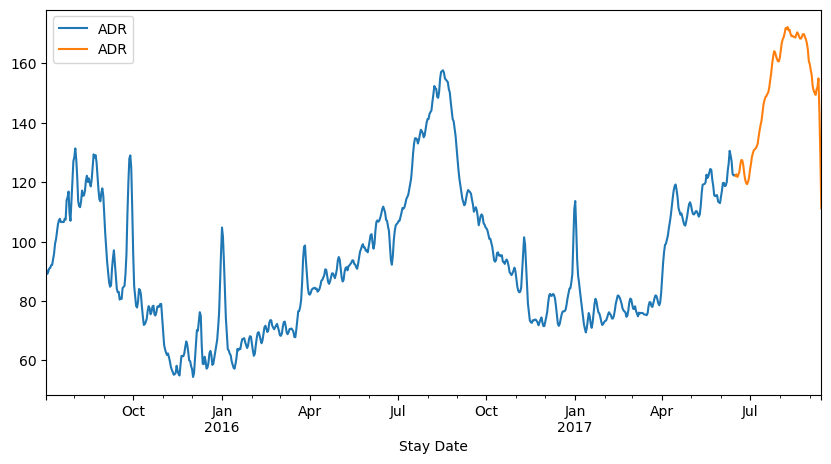

In [142]:
## Split the data into training and testing sets
train, test = train_test_split(ts_avg, test_size = 90)

fig, ax = plt.subplots(figsize=(10,5))
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')
ax.legend();

# Seasonal Decomposition

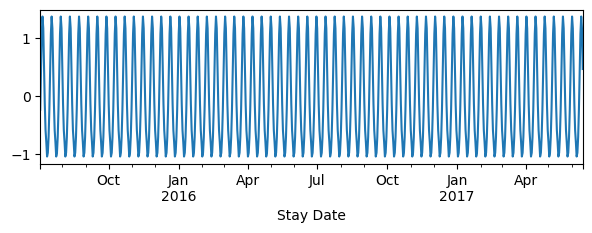

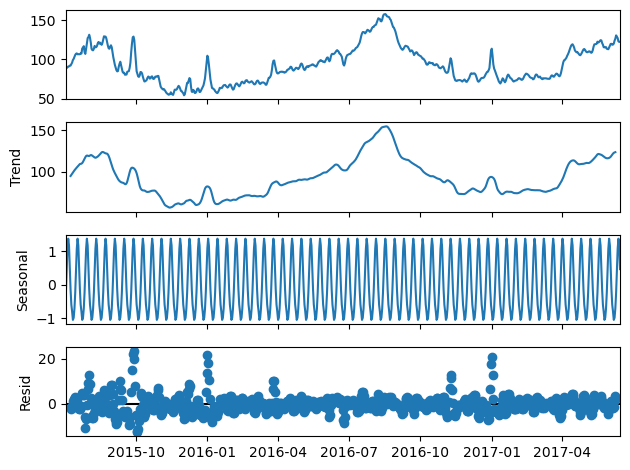

In [143]:
## Performing seasonal decomp to determine seasonality for modeling
# decomp = tsa.seasonal_decompose(split_dict['train'].loc['01-2016':'06-2016'])
decomp = tsa.seasonal_decompose(train, period =12)
decomp.seasonal.plot(figsize = (7,2));
decomp.plot();

---

**Seasonality**

> Based on the results of the seasonal decomposition, I see there is a weekly seasonality (there are four peaks/valleys per month). This matches up with my expectation that there would be regular stay/cancel patterns based on the day of the week a reservation is due to arrive.
>
> Now that I determined the seasonality, I will use it as an argument in my workflow function (created from a prior time series modeling project).

---

# Updated Modeling 

In [156]:
m = 7
k = 2#np.floor(m/2)

# Assuming you have calculated d and D values
d = ndiffs(train, test='adf')
D = nsdiffs(train, m=m, max_D=m+1)

pipeline = Pipeline([
    ('boxcox', BoxCoxEndogTransformer(lmbda2=1e-6)),
    ('fourier', FourierFeaturizer(m=m, k=k)),
    ('arima', AutoARIMA(seasonal=True, m=m, stepwise=True,
                        suppress_warnings=True, trace=False,
                        d=d, D=D
                        ))
])

pipeline.fit(train)

Pipeline(steps=[('boxcox', BoxCoxEndogTransformer(lmbda2=1e-06)),
                ('fourier', FourierFeaturizer(k=2, m=7)),
                ('arima', AutoARIMA(D=0, d=1, m=7))])

In [157]:
print(pipeline.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  714
Model:               SARIMAX(0, 1, 2)   Log Likelihood                2787.166
Date:                Mon, 01 Jul 2024   AIC                          -5558.331
Time:                        16:38:12   BIC                          -5521.775
Sample:                             0   HQIC                         -5544.212
                                - 714                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.0002      0.001      0.309      0.757      -0.001       0.001
FOURIER_S7-0     0.0015      0.001      2.278      0.023       0.000       0.003
FOURIER_C7-0    -0.0024      0.001     -3.64

## Updated Results Review

In [158]:
## Generate predictions
forecast, conf_int = pipeline.predict(n_periods = len(test),
                                      return_conf_int=True)

## Convert to DataFrame
forecast_df = (pd.DataFrame({'Lower CI': conf_int[:,0],
                             'Forecast':forecast,
                            'Upper CI':conf_int[:,1]},
                           index = test.index)
               .round(2))
forecast_df

,Lower CI,Forecast,Upper CI
Stay Date,,,
2017-06-16,119.34,123.76,128.40
2017-06-17,115.51,125.16,135.87
2017-06-18,110.33,125.80,144.16
2017-06-19,105.92,125.10,148.97
2017-06-20,101.98,123.91,152.25
...,...,...,...
2017-09-09,55.18,132.13,421.45
2017-09-10,55.15,132.82,427.94
2017-09-11,54.66,132.07,428.03


In [159]:
## Define custom function to evaluate forecast

def evaluate_forecast(y_true, y_pred, print_output=True):
    """
    Evaluate the performance of a forecast by comparing the true values with the predicted values.

    Parameters:
    - y_true (array-like): The true values of the target variable.
    - y_pred (array-like): The predicted values of the target variable.
    - print_output (bool, optional): Whether to print the evaluation metrics. Default is True.

    Returns:
    - results (dict): A dictionary containing the evaluation metrics.
        - mse (float): Mean Squared Error.
        - mae (float): Mean Absolute Error.
        - MedAE (float): Median Absolute Error.
        - mape(%) (float): Mean Absolute Percentage Error in percentage.

    Example usage:
    >>> y_true = [1, 2, 3, 4, 5]
    >>> y_pred = [1.2, 2.3, 3.5, 4.1, 5.2]
    >>> evaluate_forecast(y_true, y_pred)
    MSE: 0.10
    MAE: 0.18
    MEDAE: 0.20
    MAPE(%): 3.60

    """
    
    mse = metrics.mean_squared_error(y_true, y_pred).round(2)
    mae = metrics.mean_absolute_error(y_true, y_pred).round(2)
    medae = metrics.median_absolute_error(y_true, y_pred).round(2)
    mape = metrics.mean_absolute_percentage_error(y_true, y_pred).round(4)

    results = {'mse': mse, 'mae': mae, 'MedAE': medae, 'mape(%)': (mape * 100)}
    if print_output:
        for metric, value in results.items():
            print(f"{metric.upper()}: {value:.2f}")

    return results

In [160]:
_ = evaluate_forecast(test, forecast_df['Forecast'])

MSE: 780.94
MAE: 23.58
MEDAE: 24.30
MAPE(%): 14.72


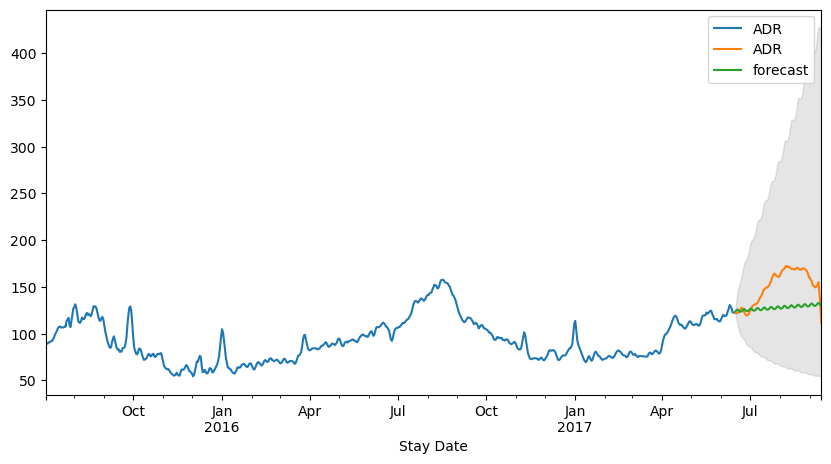

In [161]:
fig, ax = plt.subplots(figsize=(10,5))
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')
forecast_df['Forecast'].plot(ax=ax, label='forecast')
ax.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], color='k', alpha=0.1)
ax.legend();

## Review Residuals

# ***OLD Workflow***

In [54]:
raise Exception('Stop here')

Exception: Stop here

---

**I will use a functionalized workflow from my prior time series modeling work to perform my analysis and generate my forecast.**
>
> This function:
>  * Splits the data at a threshold based on either a percentage or specific period (in this case, the past 90 days)
>  * Performs SARIMA modeling via PMD's Auto-Arima to determine the optimal hyperparameters and Statsmodels's SARIMAX model for the forecasting.
>  * Generates forecasted data and 95% confidence interval for the time period set in the train/test split step.
>  * Saves the train/test split data; forecast and confidence interval data; and associated visualizations to a dictionary for review.

---

In [ ]:
## Running the workflow
# results = tsm.ts_modeling_workflow(ts_avg, threshold = -90, xlabel='Dates',
#                                    ylabel = 'Cancellations (%)',
#                                    title = 'Forecasted Cancellations', m=7,
#                                    show_vis=False)

In [ ]:
## Inspecting the keys for the resulting dictionary
# results.keys()

In [ ]:
# ##Rounding forecast data to nearest whole numbers
# results['forecasted_data'] = (results['forecasted_data']*100).round(0)
# results['forecasted_data']

In [ ]:
# ## Identifying average for the 90-day window
# results['forecasted_data'].mean().round(0)

---

**Forecast Confidence Interval**

> Based on my time series model, the hotels may expect an average of 35% daily cancellations over the next 90 days. However, there is a confidence interval of  +/- 23.5%.
>
> **This large confidence interval limits the usefulness of the forecast due to the risk of errors.** If a hotel would overbook with the expectation of the average 35% cancellation rate, only to have a 45%+ cancellation rate, it would force the hotel to relocate a large number of reservations. As relocated reservations incur significant costs (both for paying for the relocated night as well as potentially losing future business), the risk of overbooking is too great with this model's forecast.

**Reducing Risk**

> The next step of this analysis would be adjusting the model to reduce variability of the forecast results. The adjustments may include:
 * Adding additional data (holidays, presence/absence of additional demand generators)
 * Adjusting threshold values for train/test split

**Looking Forward**

> My next steps will be to evaluate the impact of shorter- and longer-term thresholds for my training data. Initially, I started with a 90-day evaluation; I will reevaluate the performance using several different thresholds to compare the impact of using different windows for forecasting.

In [ ]:
# ## Testing new thresholds for train/test split and forecast

# thresholds = [-3, -7, -15, -30, -60, -90, -180]

# ints = {}

# for threshold in thresholds:
#     results = tsm.ts_modeling_workflow(ts_avg, threshold = threshold, xlabel='Dates',
#                                        ylabel = 'Cancellations (%)',
#                                        title = 'Forecasted Cancellations',
#                                        m=7,show_vis=False)
    
#     ints[threshold*-1] = [round(results['forecasted_data']['Lower CI'].mean(), 2)*100,
#                   round(results['forecasted_data']['Forecast'].mean(), 2)*100,
#                   round(results['forecasted_data']['Upper CI'].mean(), 2)*100]

In [ ]:
# ## Combining results into DataFrame for analysis and display

# results_df = pd.DataFrame.from_dict(ints, orient = 'index')
# results_df.rename(columns = {0: 'Lower CI', 1: 'Average', 2:'Upper CI'},
#                  inplace=True)

# results_df['CI Difference'] = (results_df['Upper CI'] - results_df['Lower CI'])

# results_df.index.rename('Days Out', inplace=True)

# results_df.style.background_gradient(subset = 'CI Difference', cmap='Reds')\
#                                                             .format('{:.0f}%')

---

**Interval Impacts**

> Despite changing the threshold levels, there is little improvement in the confidence intervals.

---

# **Results and Recommendations**

## Results
---

**Best Performance:** 3/7/15 day windows
  * Guests are less likely to cancel based on prior classification modeling
  * Confidence intervals slightly smaller than longer-term perspective.
  
**Worst Performance:** 180+ days
  * Strongest likelihood of cancellations based on prior models
  * Limited benefits for on-site teams
    * Sales may use it for longer-term planning, such as business account performances or group booking trends
    * Operations may use it to identify potential spikes in occupancy/demand, guiding staffing decisions or intensive projects (such as deep cleaning, system updates, or renovations)
    
---

## Recommendations

**In my opinion, the best results came from using a 90-day threshold to forecast cancellations.**

> * **Short forecasts best for Operations:** creating schedules; ordering supplies; other time-sensitive decisions.
>  * *Limited benefit for Sales due to short window of opportunity to book groups or push business travel.*
>
>
> * **Longer Forecasts best for Sales:** booking groups and monitoring pickup; performing sales calls for targeted businesses.
>  * *Less beneficial for Operations - scheduling, purchasing supplies based on occupancy and demand.*

**Pros and Cons Based on Personal Experience/Opinions**

| Time Period (Days) | Pros | Cons | Best Use |
| --- | --- | --- | --- |
| 3, 7, 15 | Increased accuracy | Less reaction time | Operations-related decision making; scheduling |
| 30, 60, 90 | Actionable time window for Sales (group sales especially) | Less accurate; more of a "rough idea" | On-Site Sales & Marketing strategy |
| 180+ | Can identify problem areas; trends/events; and focus areas | Numbers can and will change based on bookings/cancellations | Long-term revenue management

---

## Caveats
---

***These results may not generalize well for other hotels and/or different times.***

They are meant to be guidelines and ideas for hotels to adapt to their needs. These results are specific to these two hotels for this given time period.

Each hotel is different: target clientele, amenities, locations, etc.. Additionally, larger market trends and events (locally or globally) may have positive and/or negative impacts on cancellations.

---

# Future Work

---

**Future work includes:**

* Multivariate time series modeling via variable autoregression (VAR)


* Specific breakdowns:
    * Guest type: transient, leisure, groups
    * Room type: several different room types
    * Hotel type: resort vs. city hotels


* Model deployment for hotel-specific results
---

# **Conclusion**

---

**Thank you for your interest in my work.**

This concludes my exploration of the hotel booking dataset via univariate time series analysis.

While the results are not as exact as I would prefer, I feel confident in their current state and look forward to performing additional analysis via multivariate time series modeling as well as model deployment.

**I welcome any comments or questions! Please feel free to contact me.**

---
